# [GD-04]도로 영역을 찾자! - 세그멘테이션 모델 만들기

## 00. Import

In [42]:
import os
import math
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

## 01. Data

In [43]:
def build_augmentation(is_train=True):
    if is_train:
        return Compose([
            HorizontalFlip(p=0.5),
            RandomSizedCrop(
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(
                width=224,
                height=224
            )
        ])
    return Compose([
        Resize(
            width=224,
            height=224
        )
    ])

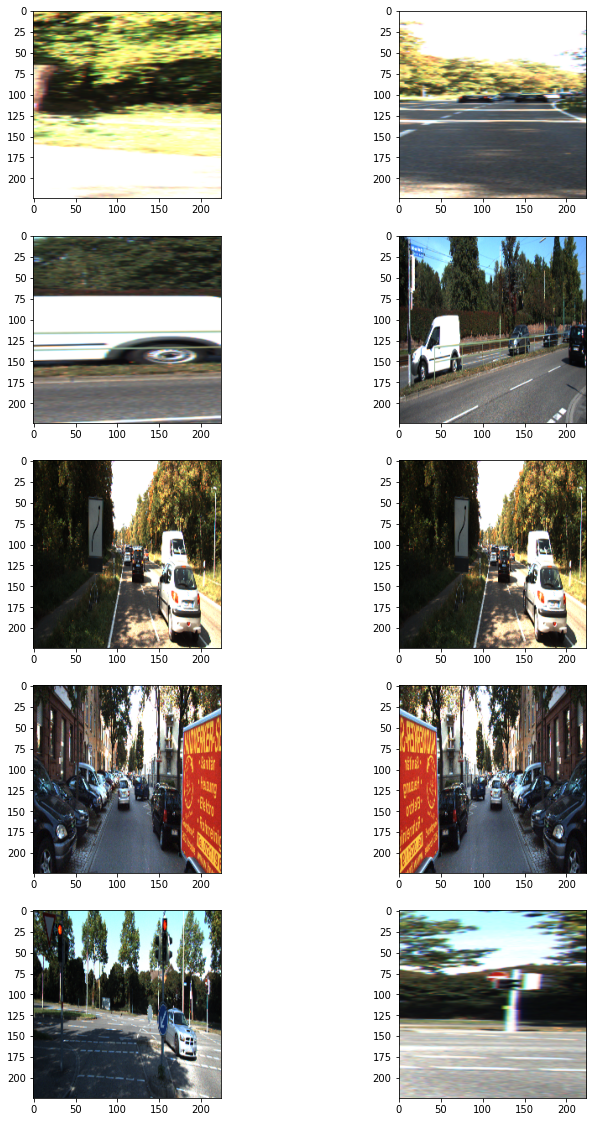

In [44]:
dir_path = '/content/drive/MyDrive/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image": image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])

plt.show()

## 02. Model

In [45]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                 dir_path,
                 batch_size=4,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):

        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [46]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    augmentation=test_preproc,
    is_train=False
)

In [47]:
def conv_batch(layer, filters):
    conv = Conv2D(filters, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(layer)
    conv = Conv2D(filters, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv)
    batch = BatchNormalization()(conv)
    
    return batch

In [48]:
def build_UNet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting path
    conv1 = conv_batch(inputs, 64)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_batch(pool1, 128)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_batch(pool2, 256)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_batch(pool3, 512)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    # Expansive path
    up1 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch5)) 
    merge1 = concatenate([conv4,up1])
    conv6 = conv_batch(merge1, 512)

    up2 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    crop_conv3 = tf.image.resize(conv3, (up2.shape[1], up2.shape[2]))
    merge2 = concatenate([crop_conv3,up2])
    conv7 = conv_batch(merge2, 256)

    up3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    crop_conv2 = tf.image.resize(conv2, (up3.shape[1], up3.shape[2]))
    merge3 = concatenate([crop_conv2,up3])
    conv8 = conv_batch(merge3, 128)

    up4 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    crop_conv1 = tf.image.resize(conv1, (up4.shape[1], up4.shape[2]))
    merge4 = concatenate([crop_conv1, up4])
    conv9 = conv_batch(merge4, 64)
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [49]:
UNet = build_UNet()
UNet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_58 (Conv2D)             (None, 222, 222, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 220, 220, 64  36928       ['conv2d_58[0][0]']              
                                )                                                           

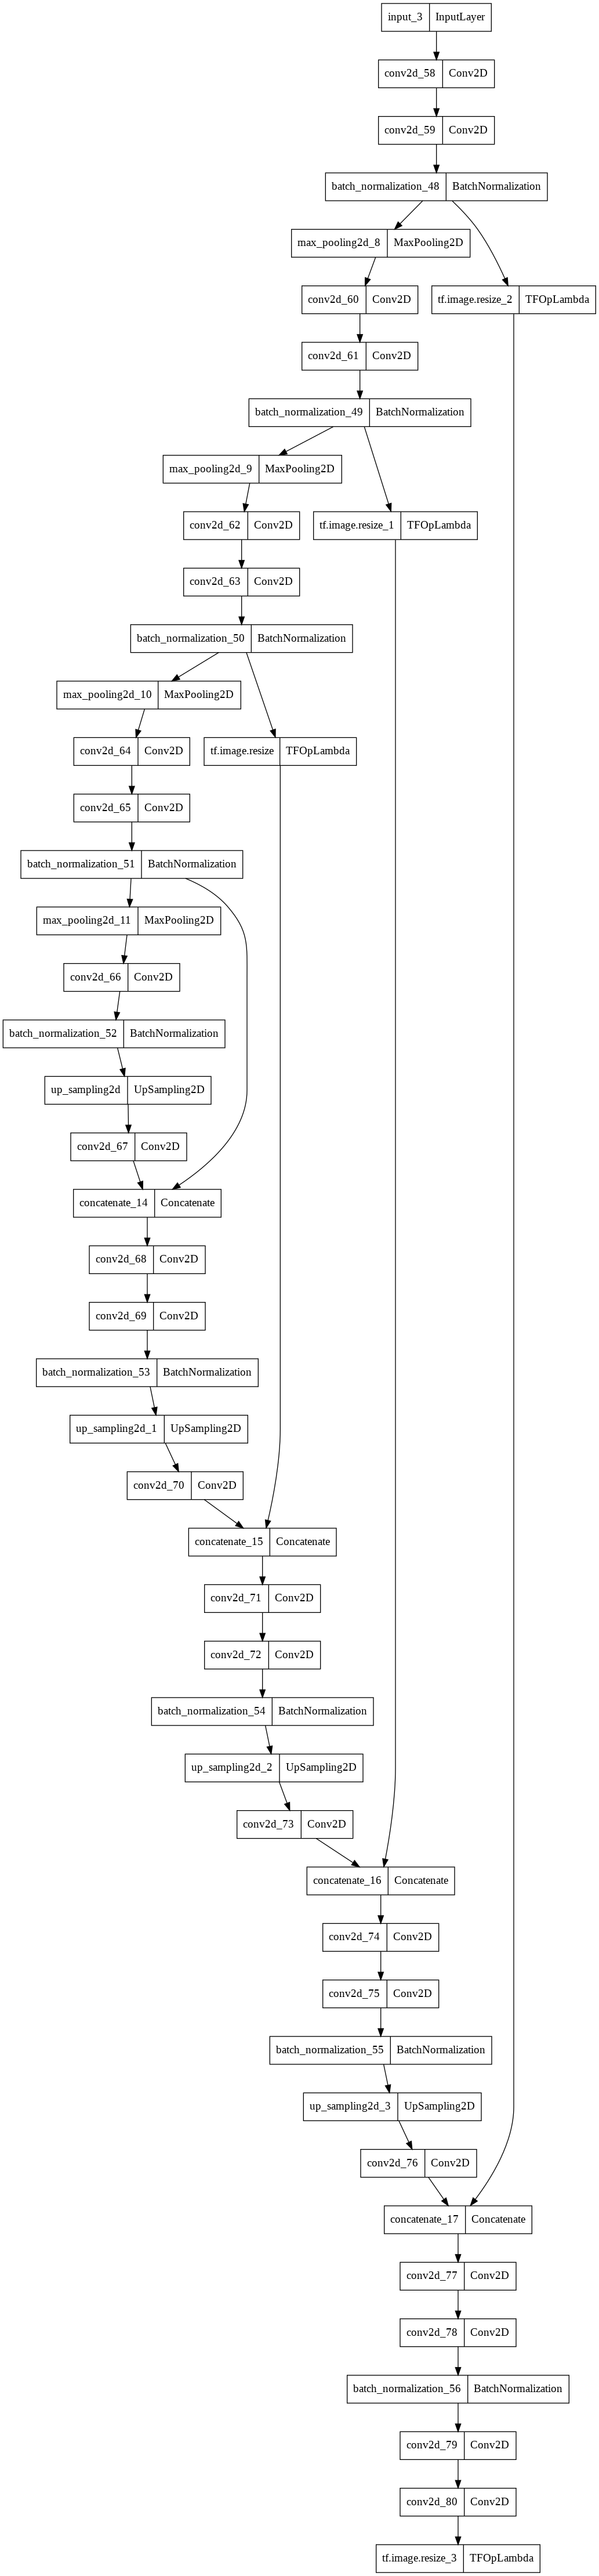

In [51]:
tf.keras.utils.plot_model(UNet, to_file='/content/drive/MyDrive/data/U-Net.png')


In [52]:
UNet.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [53]:
UNet.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


43/43 [==============================] - 20s 339ms/step - loss: 0.5765 - val_loss: 0.6466
Epoch 2/100
43/43 [==============================] - 6s 129ms/step - loss: 0.3902 - val_loss: 0.6069
Epoch 3/100
43/43 [==============================] - 6s 129ms/step - loss: 0.3200 - val_loss: 0.5080
Epoch 4/100
43/43 [==============================] - 6s 130ms/step - loss: 0.2730 - val_loss: 0.4909
Epoch 5/100
43/43 [==============================] - 6s 130ms/step - loss: 0.2496 - val_loss: 0.4967
Epoch 6/100
43/43 [==============================] - 6s 130ms/step - loss: 0.2362 - val_loss: 0.5457
Epoch 7/100
43/43 [==============================] - 6s 130ms/step - loss: 0.2109 - val_loss: 0.5619
Epoch 8/100
43/43 [==============================] - 6s 130ms/step - loss: 0.2070 - val_loss: 0.3816
Epoch 9/100
43/43 [==============================] - 6s 132ms/step - loss: 0.1984 - val_loss: 0.2780
Epoch 10/100
43/43 [==============================] - 6s 132ms/step - loss: 0.1912 - val_loss: 0.2259


In [54]:
UNet_model_path = '/content/drive/MyDrive/data/seg_model_unet.h5'
UNet.save(UNet_model_path)

In [55]:
def build_UNet_plus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting path(Backbone)
    conv1 = conv_batch(inputs, 64)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_batch(pool1, 128)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_batch(pool2, 256)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_batch(pool3, 512)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    
    # Re-designed skip pathways
    # conv1_1, conv2_1, conv3_1
    up_conv2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2.shape[1], up_conv2.shape[2]))
    merge1_1 = concatenate([skip_crop_conv1, up_conv2])
    conv1_1 = conv_batch(merge1_1, 64)
    
    up_conv3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3))
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3.shape[1], up_conv3.shape[2]))
    merge2_1 = concatenate([skip_crop_conv2 , up_conv3])
    conv2_1 = conv_batch(merge2_1, 128)
    
    up_conv4 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4))
    skip_crop_conv3 = tf.image.resize(conv3, (up_conv4.shape[1], up_conv4.shape[2]))
    merge3_1 = concatenate([skip_crop_conv3, up_conv4])
    conv3_1 = conv_batch(merge3_1, 256)
    
    # conv1_2, conv2_2
    up_conv2_1 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    merge1_2 = concatenate([skip_crop_conv1, skip_crop_conv1_1, up_conv2_1])
    conv1_2 = conv_batch(merge1_2, 64)
    
    up_conv3_1 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1))
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    skip_crop_conv2_1 = tf.image.resize(conv2_1, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    merge2_2 = concatenate([skip_crop_conv2, skip_crop_conv2_1, up_conv3_1])
    conv2_2 = conv_batch(merge2_2, 256)

    # conv1_3
    up_conv2_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_2 = tf.image.resize(conv1_2, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    merge1_3 = concatenate([skip_crop_conv1, skip_crop_conv1_1, skip_crop_conv1_2, up_conv2_2])
    conv1_3 = conv_batch(merge1_3, 64)
    
    
    # Expansive path
    up1 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch5)) 
    merge1 = concatenate([conv4,up1])
    conv6 = conv_batch(merge1, 512)

    up2 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    crop_conv3 = tf.image.resize(conv3, (up2.shape[1], up2.shape[2]))
    crop_conv3_1 = tf.image.resize(conv3_1, (up2.shape[1], up2.shape[2]))
    merge2 = concatenate([crop_conv3, crop_conv3_1, up2])
    conv7 = conv_batch(merge2, 256)

    up3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    crop_conv2 = tf.image.resize(conv2, (up3.shape[1], up3.shape[2]))
    crop_conv2_1 = tf.image.resize(conv2_1, (up3.shape[1], up3.shape[2]))
    crop_conv2_2 = tf.image.resize(conv2_2, (up3.shape[1], up3.shape[2]))
    merge3 = concatenate([crop_conv2, crop_conv2_1, crop_conv2_2, up3])
    conv8 = conv_batch(merge3, 128)

    up4 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    crop_conv1 = tf.image.resize(conv1, (up4.shape[1], up4.shape[2]))
    crop_conv1_1 = tf.image.resize(conv1_1, (up4.shape[1], up4.shape[2]))
    crop_conv1_2 = tf.image.resize(conv1_2, (up4.shape[1], up4.shape[2]))
    crop_conv1_3 = tf.image.resize(conv1_3, (up4.shape[1], up4.shape[2]))
    merge4 = concatenate([crop_conv1, crop_conv1_1, crop_conv1_2, crop_conv1_3, up4])
    conv9 = conv_batch(merge4, 64)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [56]:
UNet_plus = build_UNet_plus()
UNet_plus.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_81 (Conv2D)             (None, 222, 222, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_82 (Conv2D)             (None, 220, 220, 64  36928       ['conv2d_81[0][0]']              
                                )                                                           

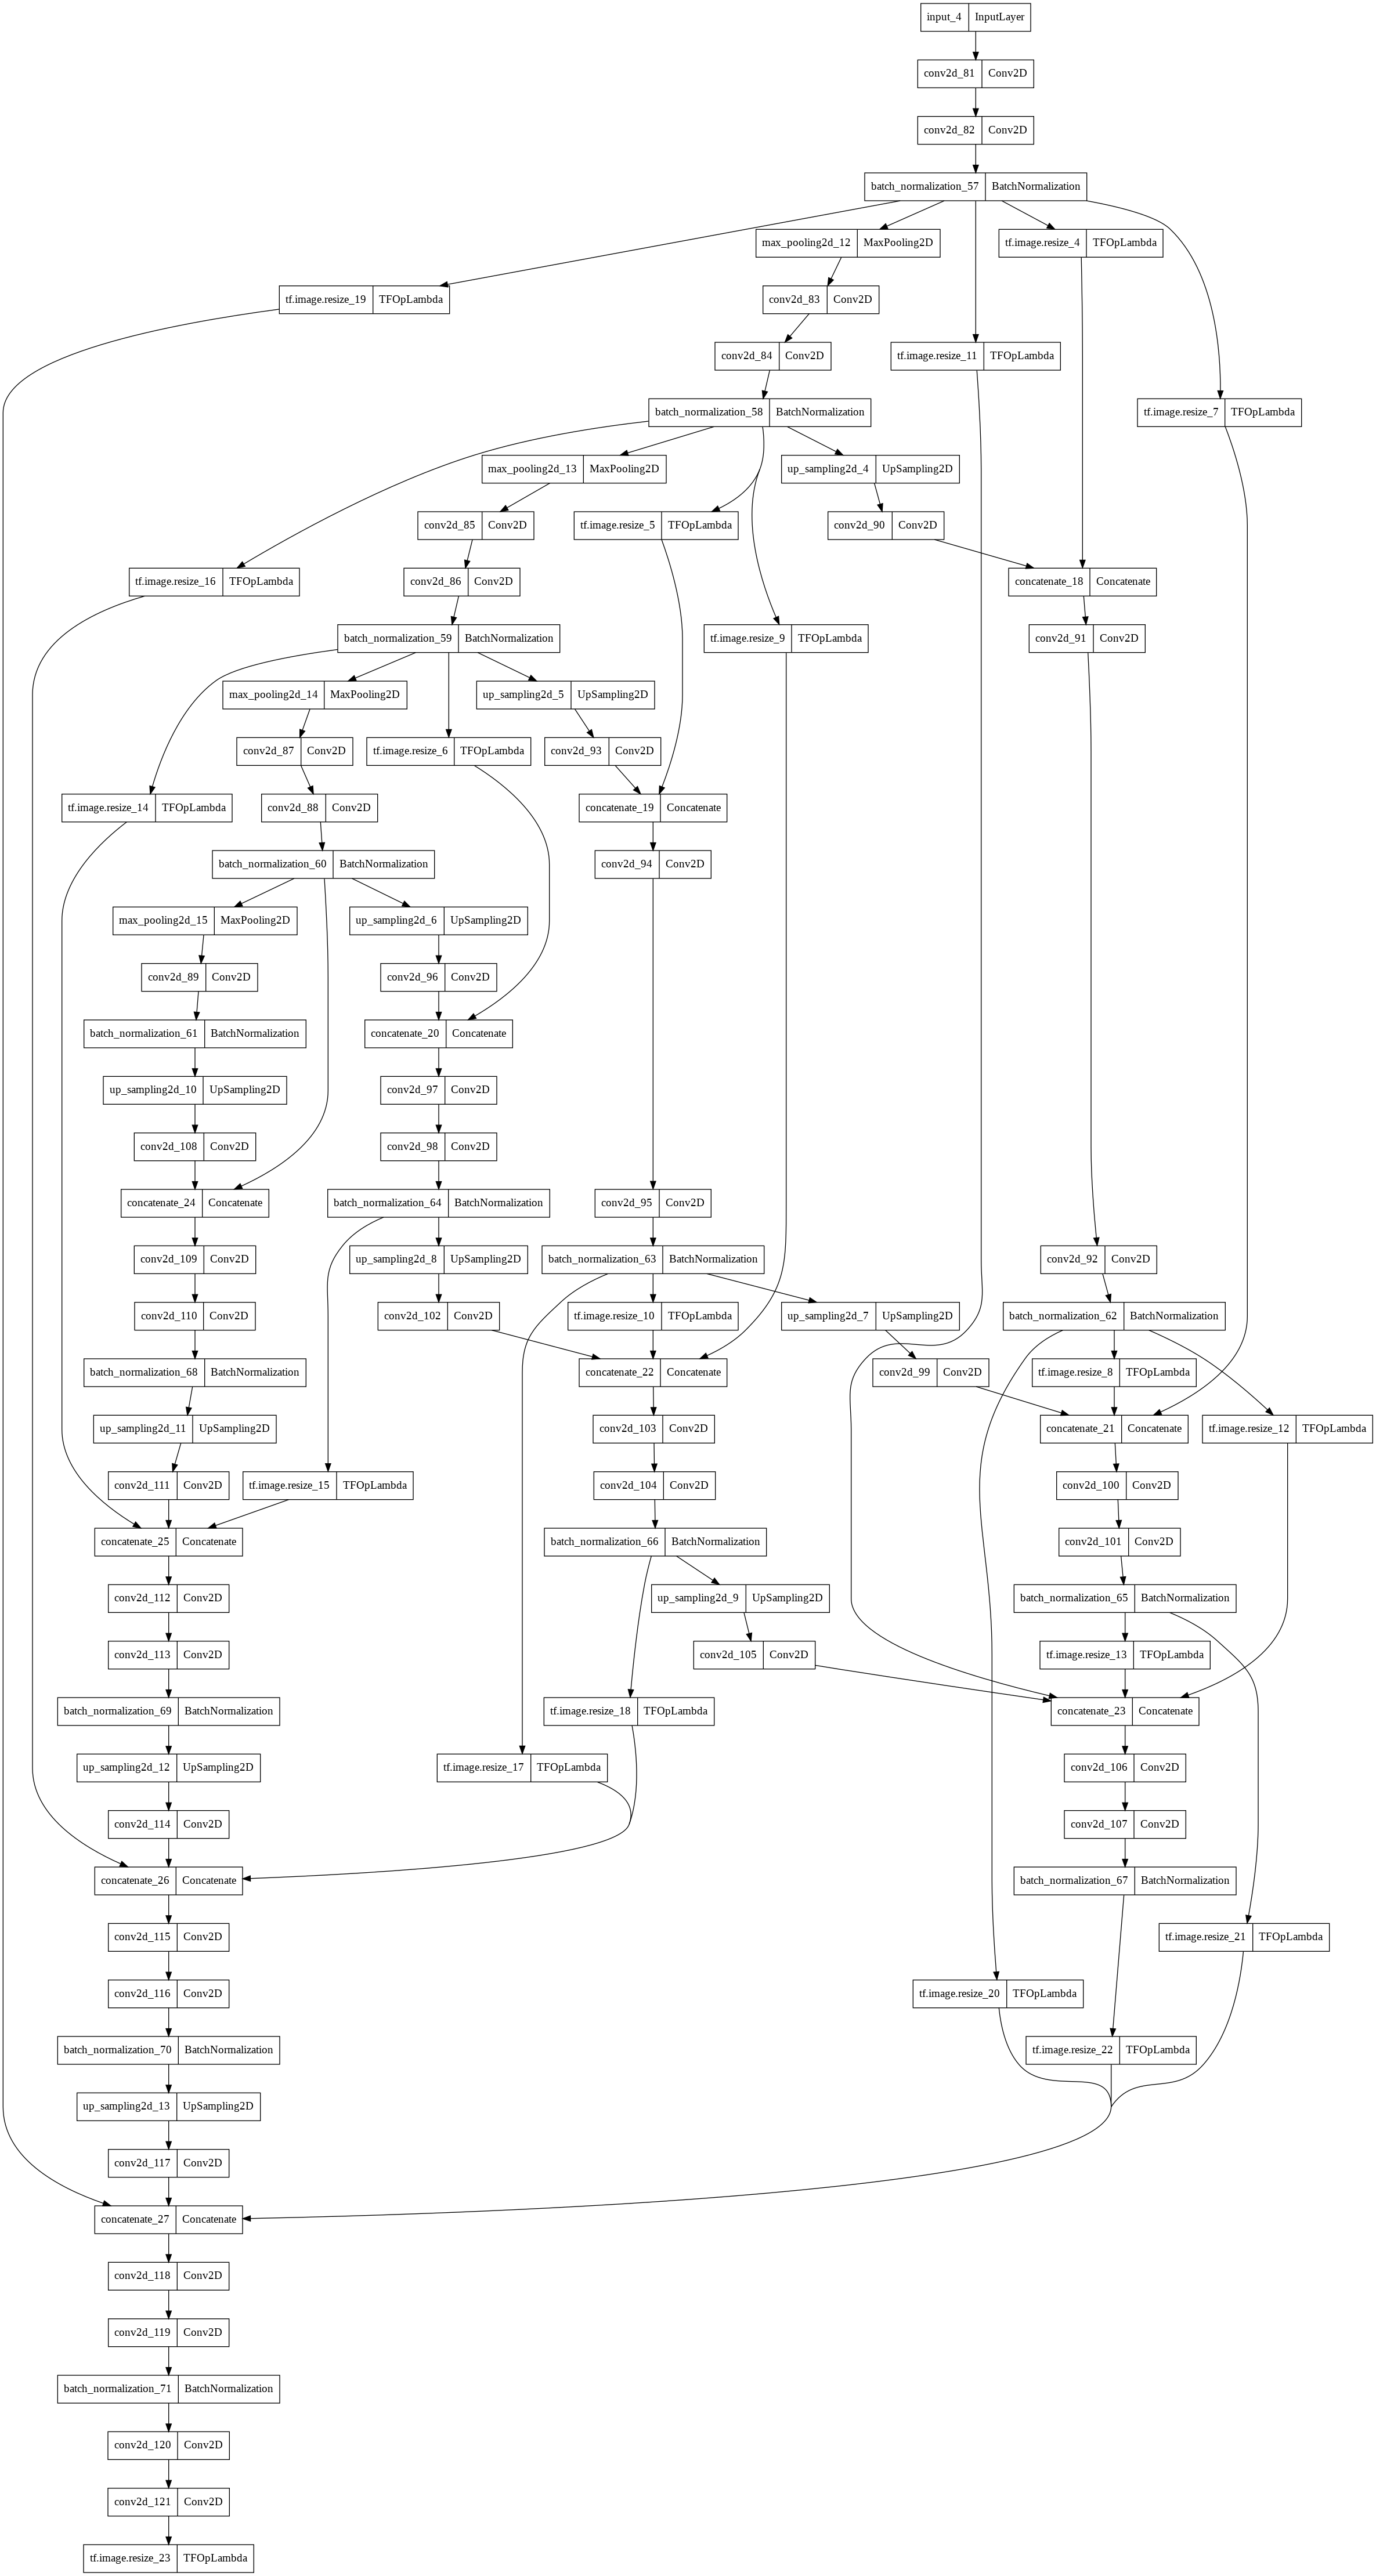

In [57]:
tf.keras.utils.plot_model(UNet_plus, to_file='/content/drive/MyDrive/data/U-Net++.png')


In [58]:
UNet_plus.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [59]:
UNet_plus.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


43/43 [==============================] - 33s 550ms/step - loss: 0.6400 - val_loss: 0.5859
Epoch 2/100
43/43 [==============================] - 19s 431ms/step - loss: 0.5046 - val_loss: 0.6159
Epoch 3/100
43/43 [==============================] - 18s 428ms/step - loss: 0.4670 - val_loss: 0.6136
Epoch 4/100
43/43 [==============================] - 18s 426ms/step - loss: 0.4547 - val_loss: 0.6130
Epoch 5/100
43/43 [==============================] - 18s 428ms/step - loss: 0.4375 - val_loss: 0.5578
Epoch 6/100
43/43 [==============================] - 18s 429ms/step - loss: 0.4254 - val_loss: 0.4117
Epoch 7/100
43/43 [==============================] - 18s 430ms/step - loss: 0.4136 - val_loss: 0.2019
Epoch 8/100
43/43 [==============================] - 18s 429ms/step - loss: 0.4132 - val_loss: 0.1736
Epoch 9/100
43/43 [==============================] - 18s 429ms/step - loss: 0.4084 - val_loss: 0.4675
Epoch 10/100
43/43 [==============================] - 18s 429ms/step - loss: 0.4202 - val_loss

In [60]:
UNet_plus_model_path = '/content/drive/MyDrive/data/seg_model_unet_plus.h5'
UNet.save(UNet_plus_model_path)

In [61]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return

In [62]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    
    plt.figure(figsize=(12, 20))
    plt.imshow(output)

    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

IoU : 0.773071


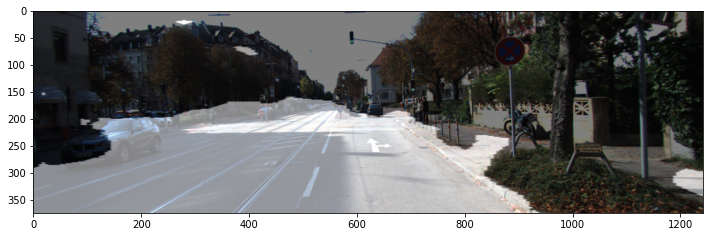

In [63]:
i = 1
output, prediction, target = get_output(
     UNet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.884921


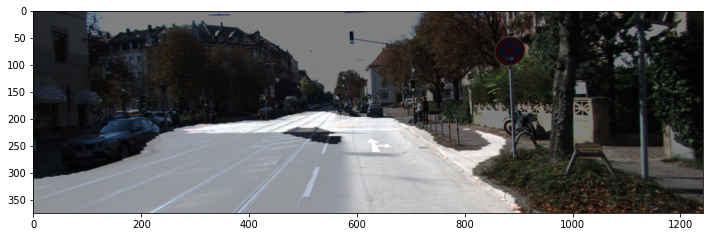

In [64]:
i = 1
output, prediction, target = get_output(
     UNet_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)